In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric


import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
df=pd.read_csv('/content/drive/My Drive/airline_passengers.csv')

In [4]:
df.columns=['date','passengers']

In [5]:
df.head()

,date,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
#dropping null values
df.dropna(inplace=True)

In [7]:
df['date']=pd.to_datetime(df['date'])

In [8]:
df.set_index('date',inplace=True)

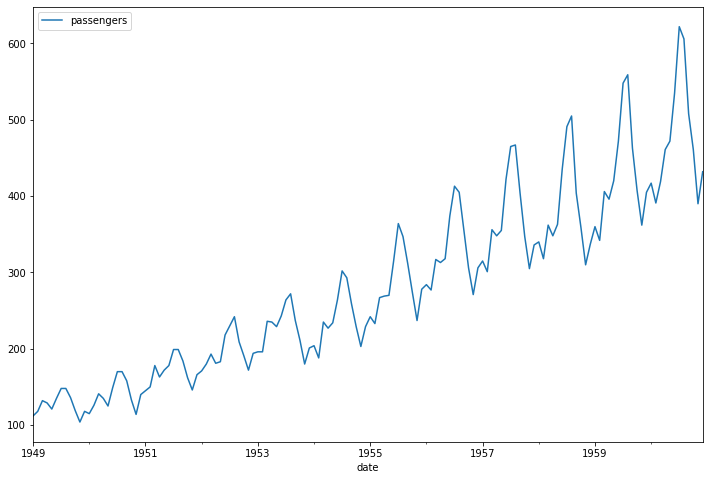

In [9]:
df.plot(figsize=(12,8))

In [10]:
decomposition=seasonal_decompose(df)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

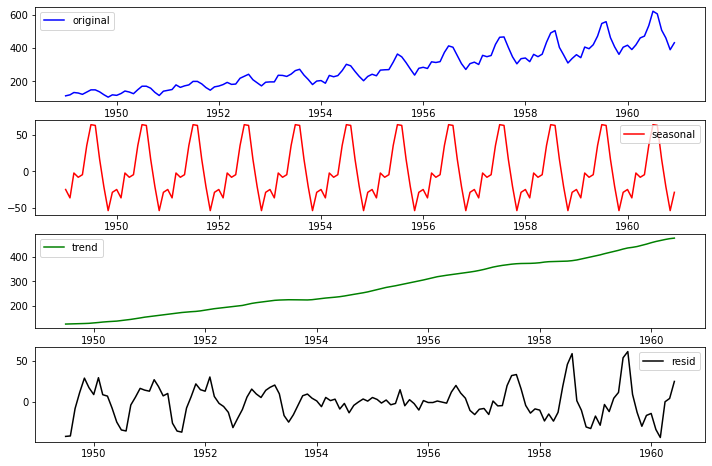

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df,label='original',color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal,label='seasonal',color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='trend',color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='resid',color='black')
plt.legend(loc='best')

In [12]:
# Finding if data is seasonal

In [13]:
# rolling mean & std
roll_mean=df.rolling(window=8).mean()
roll_std=df.rolling(window=8).std()

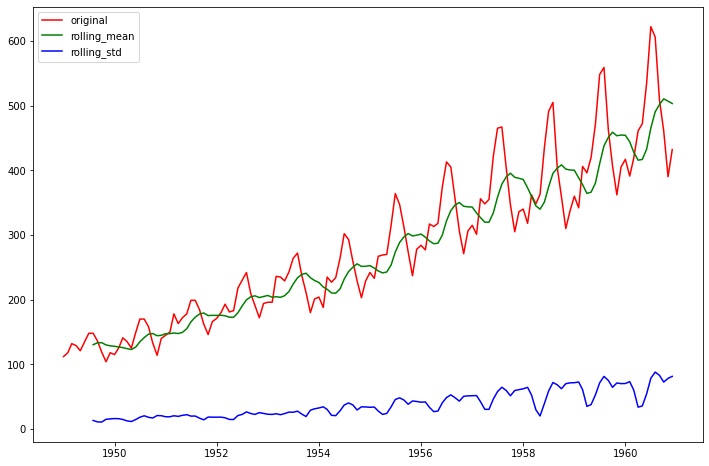

In [14]:
fig=plt.figure(figsize=(12,8))
plt.plot(df,color='red',label='original')
plt.plot(roll_mean,color='green',label='rolling_mean')
plt.plot(roll_std,color='blue',label='rolling_std')
plt.legend(loc='best')
plt.show()

In [15]:
# dickeyfuller test
dftest=adfuller(df['passengers'])
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)



(0.815368879206047, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
Results of Dickey-Fuller test: 

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
# function to chect stationary

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['passengers'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


In [17]:
# lets make the data stationary

In [18]:
# log transformation
log_df=np.log(df)

In [19]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean=log_df.ewm(halflife=4).mean()

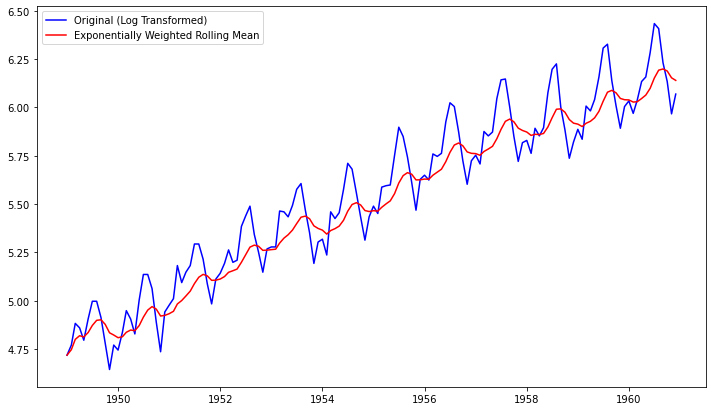

In [20]:
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

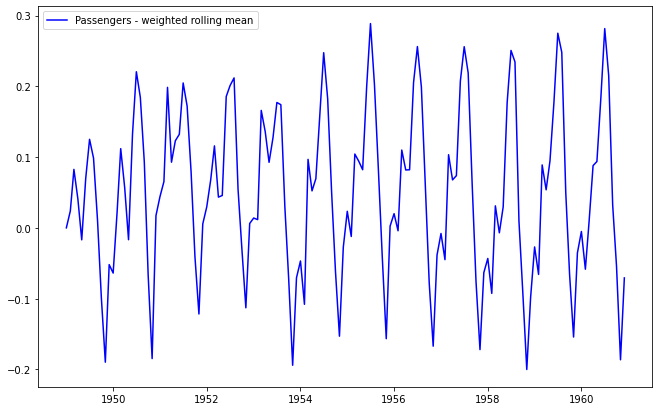

In [21]:
# substracting ewm from log data
data_minus_exp_roll_mean = np.log(df) - exp_roll_mean
# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

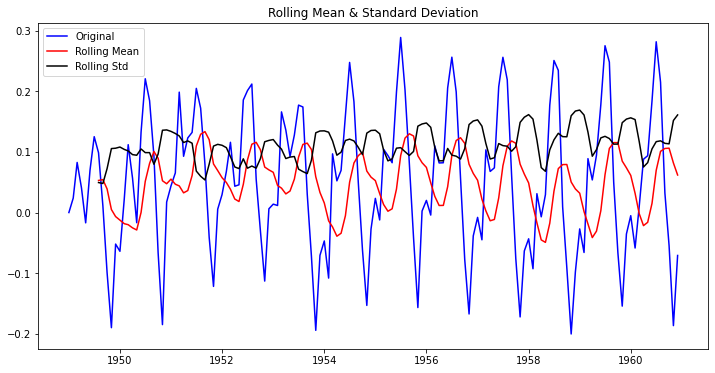

Results of Dickey-Fuller Test: 

Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
stationarity_check(data_minus_exp_roll_mean)

In [23]:
# differencing
data_diff=data_minus_exp_roll_mean.diff(periods=12)
data_diff.dropna(inplace=True)

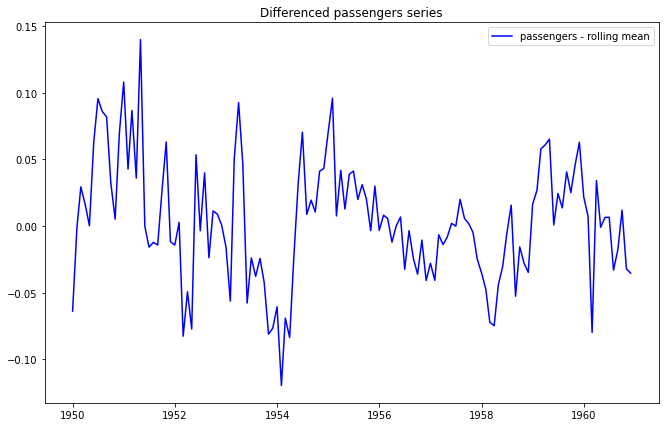

In [24]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='passengers - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)


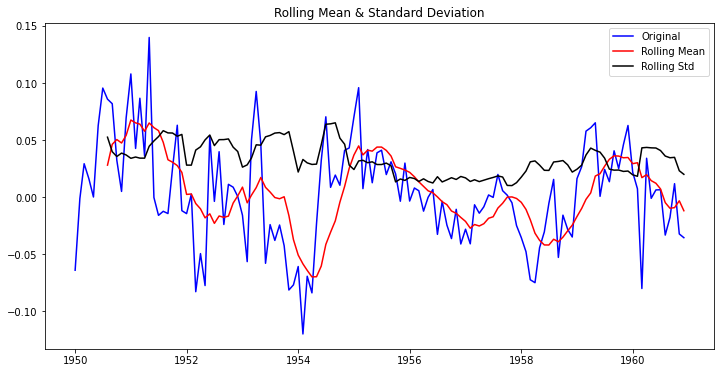

Results of Dickey-Fuller Test: 

Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [25]:
stationarity_check(data_diff)

In [26]:
# ACF & Pacf

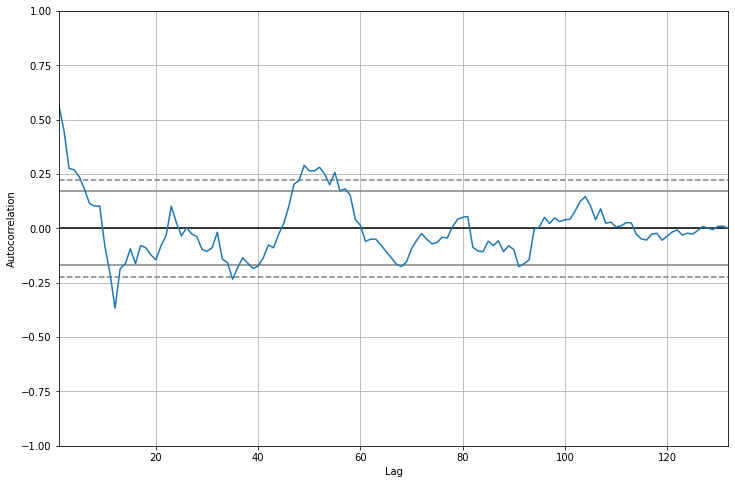

In [27]:
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(data_diff)

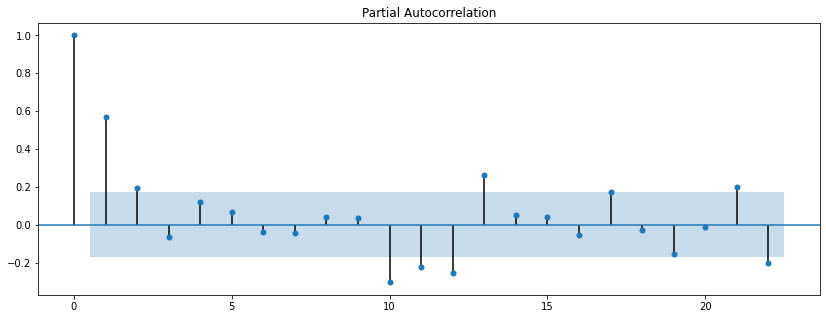

In [28]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(data_diff);

Facebook Prophet

In [29]:
fb=pd.read_csv('/content/drive/My Drive/airline_passengers.csv')

In [30]:
fb.columns=['ds','y']

In [31]:
fb.dropna(inplace=True)

In [32]:
fb['ds']=pd.to_datetime(fb.ds)

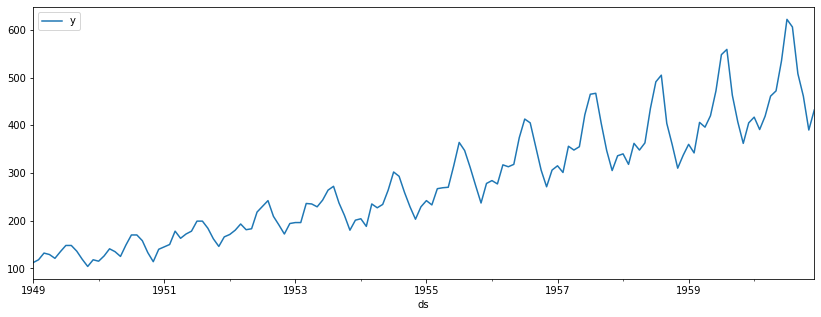

In [33]:
fb.plot(x='ds',y='y')

In [34]:
len(fb)

144

In [35]:
train=fb[:132]
test=fb[132:]

In [36]:
m=Prophet(seasonality_mode='multiplicative')
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future=m.make_future_dataframe(periods=12,freq='MS')

In [38]:
forecast=m.predict(future)

In [39]:
fb.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [40]:
forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper',
       'multiplicative_terms', 'yearly', 'yearly_lower', 'yearly_upper',
       'yhat']].head()

,ds,trend,yhat_lower,yhat_upper,multiplicative_terms,yearly,yearly_lower,yearly_upper,yhat
0,1949-01-01,115.603966,90.626533,116.137181,-0.101135,-0.101135,-0.101135,-0.101135,103.912403
1,1949-02-01,117.275019,86.721599,111.469782,-0.154216,-0.154216,-0.154216,-0.154216,99.189377
2,1949-03-01,118.784358,106.256396,131.302803,0.002721,0.002721,0.002721,0.002721,119.107520
3,1949-04-01,120.455412,103.858189,128.828124,-0.033256,-0.033256,-0.033256,-0.033256,116.449565
4,1949-05-01,122.072561,105.697866,131.204459,-0.027357,-0.027357,-0.027357,-0.027357,118.733027


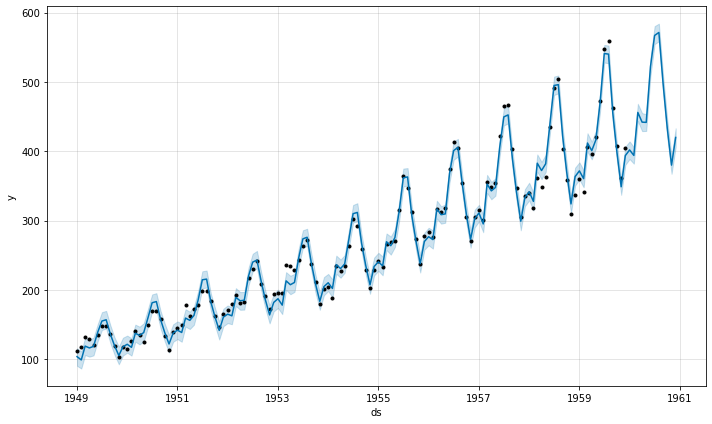

In [41]:
m.plot(forecast);

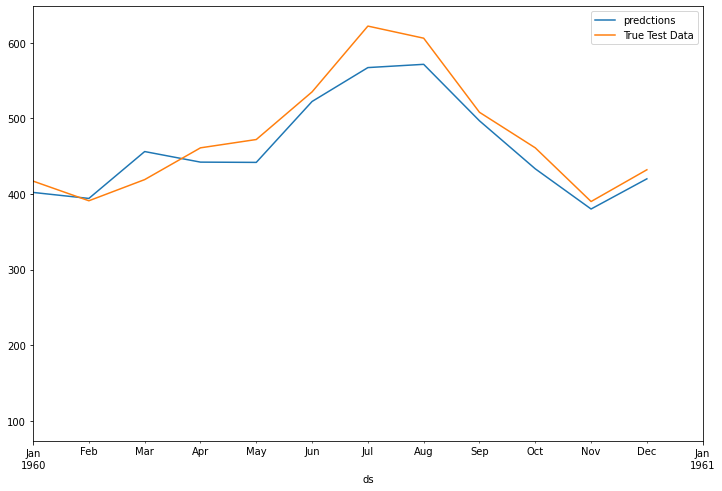

In [42]:
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predctions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('1960-01-01','1961-01-01'))

In [43]:
predictions=forecast.iloc[-12:]['yhat']
predictions

132    402.022536
133    394.089864
134    456.083466
135    442.095362
136    441.751847
137    522.309634
138    567.116400
139    571.429406
140    496.740080
141    433.249511
142    380.107580
143    420.009049
Name: yhat, dtype: float64

In [44]:
test['y']

132    417.0
133    391.0
134    419.0
135    461.0
136    472.0
137    535.0
138    622.0
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Name: y, dtype: float64

In [45]:
rmse(predictions,test['y'])

26.439065952225352

In [46]:
# Intial
initial= 2*365
initial= str(initial)+' days'

initial

'730 days'

In [47]:
period= 2*365
period=str(period)+' days'

period

'730 days'

In [48]:
horizon = 365
horizon=str(horizon)+' days'
horizon

'365 days'

In [49]:
fb_cv=cross_validation(m,initial=initial,period=period,horizon=horizon)

INFO:fbprophet:Making 4 forecasts with cutoffs between 1952-12-02 00:00:00 and 1958-12-01 00:00:00


In [50]:
len(fb_cv)

48

In [51]:
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days,83.598344,9.143213,8.115745,0.028862,0.025992,0.50
1,61 days,105.318032,10.262457,8.838081,0.035475,0.025992,0.50
2,62 days,235.355447,15.341299,13.616275,0.051180,0.057404,0.25
3,89 days,177.936300,13.339277,10.713799,0.035330,0.038033,0.25
4,90 days,60.238763,7.761363,5.135259,0.016651,0.013268,0.50
5,120 days,196.437363,14.015611,12.092810,0.044147,0.049594,0.25
6,121 days,190.007762,13.784330,12.094159,0.044296,0.048650,0.25
7,150 days,122.607723,11.072837,9.733939,0.035413,0.037681,0.25
8,151 days,151.376528,12.303517,11.810656,0.039455,0.037176,0.25
9,181 days,409.895821,20.245884,15.433814,0.045871,0.028428,0.50


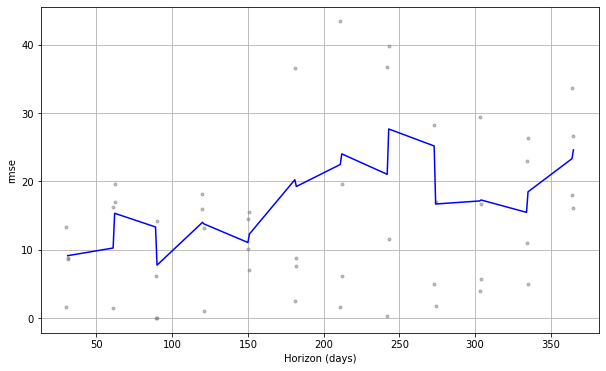

In [52]:
plot_cross_validation_metric(fb_cv,'rmse');

In [53]:
# changing trend points

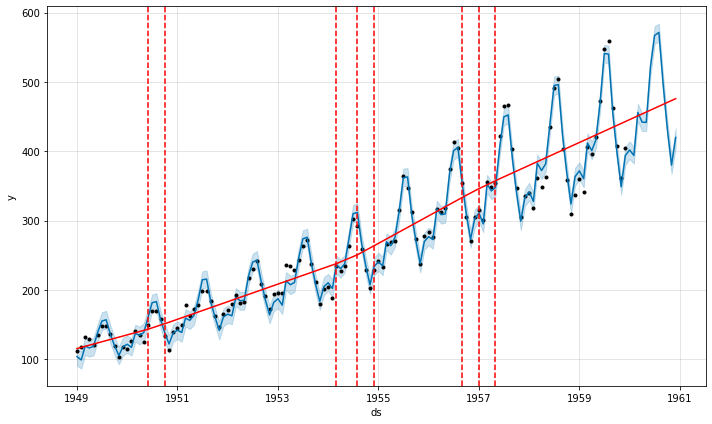

In [54]:
from fbprophet.plot import add_changepoints_to_plot
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)

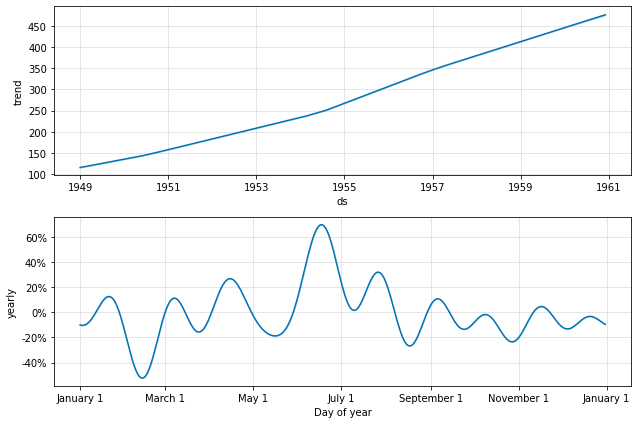

In [55]:
# changing seasonality

fig=m.plot_components(forecast);

Deep Learning

In [56]:
train=df[:132]
test=df[132:]

In [57]:
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [58]:
n_input=12
n_features=1

In [59]:
train_generator=TimeseriesGenerator(scaled_train,scaled_train,n_input,batch_size=1)

In [60]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(train_generator,epochs=30)

Epoch 1/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0416
Epoch 2/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0122
Epoch 3/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0104
Epoch 4/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0089
Epoch 5/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0109
Epoch 6/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0079
Epoch 7/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0077
Epoch 8/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0069
Epoch 9/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0067
Epoch 10/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0043
Epoch 11/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0110
Epoch 12/30
120/120 [==============================] - 2s 18ms/step - loss: 0.0099
Epoch 13/30
1

In [63]:
model.history.history.keys()

dict_keys(['loss'])

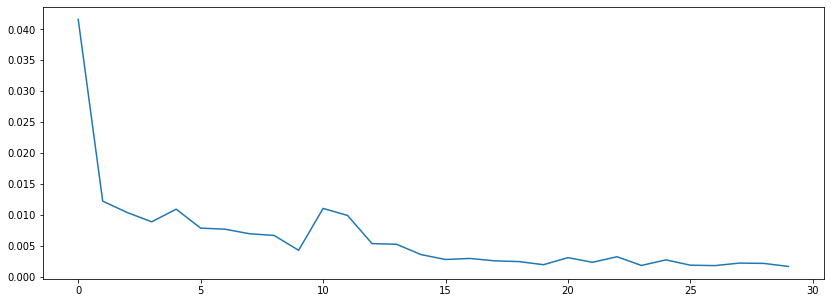

In [64]:
myloss=model.history.history['loss']
plt.plot(range(len(myloss)),myloss)

In [65]:
first_eval_batch=scaled_train[-12:]

In [66]:
first_eval_batch

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

In [67]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [68]:
model.predict(first_eval_batch)

array([[0.6202988]], dtype=float32)

In [69]:
scaled_test[0]

array([0.68791209])

In [70]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
test_predictions

[array([0.6202988], dtype=float32),
 array([0.64346236], dtype=float32),
 array([0.6936955], dtype=float32),
 array([0.73492897], dtype=float32),
 array([0.8089953], dtype=float32),
 array([0.91829586], dtype=float32),
 array([1.0247341], dtype=float32),
 array([1.0466713], dtype=float32),
 array([0.9151089], dtype=float32),
 array([0.7626887], dtype=float32),
 array([0.6963489], dtype=float32),
 array([0.68427455], dtype=float32)]

In [72]:
scaled_test

array([[0.68791209],
       [0.63076923],
       [0.69230769],
       [0.78461538],
       [0.80879121],
       [0.94725275],
       [1.13846154],
       [1.1032967 ],
       [0.88791209],
       [0.78461538],
       [0.62857143],
       [0.72087912]])

In [73]:
true_predictions = scaler.inverse_transform(test_predictions)

In [74]:
true_predictions

array([[386.2359553 ],
       [396.77537376],
       [419.63144594],
       [438.39267933],
       [472.09286445],
       [521.82461643],
       [570.25403345],
       [580.23542845],
       [520.37455821],
       [451.02335685],
       [420.83875203],
       [415.34492218]])

In [75]:
test

,passengers
date,
1960-01-01,417.0
1960-02-01,391.0
1960-03-01,419.0
1960-04-01,461.0
1960-05-01,472.0
1960-06-01,535.0
1960-07-01,622.0
1960-08-01,606.0
1960-09-01,508.0


In [76]:
test['Predictions'] = true_predictions

In [77]:
test

,passengers,Predictions
date,,
1960-01-01,417.0,386.235955
1960-02-01,391.0,396.775374
1960-03-01,419.0,419.631446
1960-04-01,461.0,438.392679
1960-05-01,472.0,472.092864
1960-06-01,535.0,521.824616
1960-07-01,622.0,570.254033
1960-08-01,606.0,580.235428
1960-09-01,508.0,520.374558


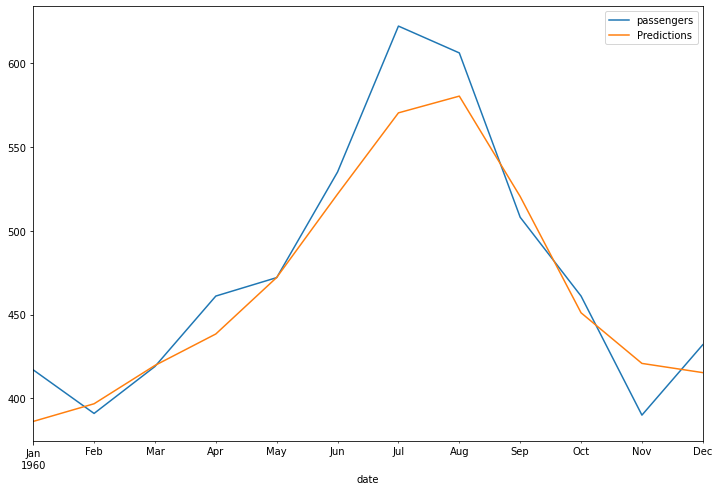

In [78]:
test.plot(figsize=(12,8))